In [1]:
# # Install pyspark

# !pip install pyspark
# !pip install -U -q PyDrive
# !apt install openjdk-8-jdk-headless -qq

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [1]:
# Import libraries

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import tqdm
import psutil
import time
import math
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

import pandas
import similaritymeasures
import altair as alt
import geopandas as gpd
import requests
# from google.colab import drive

In [2]:
# Create spark session
spark = SparkSession.builder.getOrCreate()

# Create spark context
sc = spark.sparkContext

# Check how much memory is allocated to spark runtime
mem_info = psutil.virtual_memory()
total_memory_gb = mem_info.total / (1024 * 1024 * 1024)
print("Total Memory Allocated to Spark Runtime:", int(total_memory_gb), "GB")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/01 16:29:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Total Memory Allocated to Spark Runtime: 8 GB


In [3]:
# Mount google drive
# drive.mount('/content/drive')

In [4]:
# Load data
folder = 'data/2023-citibike-tripdata/9_September/'
name = '202309-citibike-tripdata_4.csv'
path = folder + name

sep23_data = spark.read.csv(path, sep = ',', header = True, inferSchema = True)

In [5]:
# Choose which data-set
data = sep23_data

# View data
print(f"NUM DATA POINTS = {data.count()}")
data.show()

NUM DATA POINTS = 575162
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|         ride_id|rideable_type|         started_at|           ended_at|  start_station_name|start_station_id|    end_station_name|end_station_id|         start_lat|         start_lng|          end_lat|           end_lng|member_casual|
+----------------+-------------+-------------------+-------------------+--------------------+----------------+--------------------+--------------+------------------+------------------+-----------------+------------------+-------------+
|E7CE7CE80519EB26| classic_bike|2023-09-16 17:15:28|2023-09-16 17:19:00|Halsey St & Ralph...|         4334.02|Broadway & Madiso...|       4483.10|          40.68494|         -73.92299|         40.68822|         -73.91966|       member|
|56F4C65B769CF128| classic_bike

In [6]:
# Project only relevant columns
projected_data = data.select("started_at", "ended_at", "start_lat", "start_lng",
                  "end_lat", "end_lng")

# Select a small sample (first N) of rows
N = 100
small_data = projected_data.select("*").limit(N)
small_data.show()

+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|         started_at|           ended_at|         start_lat|         start_lng|          end_lat|           end_lng|
+-------------------+-------------------+------------------+------------------+-----------------+------------------+
|2023-09-16 17:15:28|2023-09-16 17:19:00|          40.68494|         -73.92299|         40.68822|         -73.91966|
|2023-09-03 21:45:29|2023-09-03 21:53:33|       40.73240447|     -73.998393893|        40.722055|        -73.989111|
|2023-09-06 11:59:58|2023-09-06 12:23:02| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|
|2023-09-20 09:09:07|2023-09-20 09:14:27|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|
|2023-09-06 20:34:25|2023-09-06 20:41:56| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|
|2023-09-06 21:14:06|2023-09-06 21:36:29| 40.78232260730881|-73.

## code from katie

In [7]:
# Function to process start and end times of day into pure seconds

def extract_times_to_seconds(rdd):


    # Split started_at and ended_at columns into date and time
    rdd = rdd.withColumn("start_date", split(col("started_at"), " ")[0]) \
          .withColumn("start_time", split(col("started_at"), " ")[1]) \
          .withColumn("end_date", split(col("ended_at"), " ")[0]) \
          .withColumn("end_time", split(col("ended_at"), " ")[1])


    # Drop the original started_at and ended_at columns
    rdd = rdd.drop("started_at", "ended_at")


    # Split the time strings into hours, minutes, and seconds
    rdd = rdd.withColumn("start_time_split", split(col("start_time"), ":")) \
          .withColumn("end_time_split", split(col("end_time"), ":"))


    # Convert hours, minutes, seconds to seconds
    rdd = rdd.withColumn("start_seconds",
                      col("start_time_split")[0].cast("int") * 3600 +
                      col("start_time_split")[1].cast("int") * 60 +
                      col("start_time_split")[2].cast("int")) \
          .withColumn("end_seconds",
                      col("end_time_split")[0].cast("int") * 3600 +
                      col("end_time_split")[1].cast("int") * 60 +
                      col("end_time_split")[2].cast("int"))


    # Drop intermediate columns
    rdd = rdd.drop("start_time_split", "end_time_split")


    # Drop all date and time columns EXCEPT for the new 'seconds' columns
    rdd = rdd.drop("start_date", "start_time", "end_date", "end_time")


    return rdd


# Test function
test = extract_times_to_seconds(small_data)
test.show()

+------------------+------------------+-----------------+------------------+-------------+-----------+
|         start_lat|         start_lng|          end_lat|           end_lng|start_seconds|end_seconds|
+------------------+------------------+-----------------+------------------+-------------+-----------+
|          40.68494|         -73.92299|         40.68822|         -73.91966|        62128|      62340|
|       40.73240447|     -73.998393893|        40.722055|        -73.989111|        78329|      78813|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        43198|      44582|
|40.750097682094825|-73.91349703073502|        40.756913|        -73.921631|        32947|      33267|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        74065|      74516|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.96680057048798|        76446|      77789|
| 40.78232260730881|-73.95987510681152|40.78866499127884|-73.966800570487

In [8]:
# Function to compute the true distance between two points on Earth's surface

def haversine(lat1, lon1, lat2, lon2):


    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)


    # Radius of the Earth in kilometers
    radius = 6371.0


    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = radius * c


    return distance

In [9]:
# Helper function to find the distance between the starting points of two trips
def starts_dist(u, v):

    lat1 = u[0]
    lon1 = u[1]
    lat2 = v[0]
    lon2 = v[1]

    return haversine(lat1, lon1, lat2, lon2);


# Helper function to find the distance between the ending points of two trips
def ends_dist(u, v):

    lat1 = u[2]
    lon1 = u[3]
    lat2 = v[2]
    lon2 = v[3]

    return haversine(lat1, lon1, lat2, lon2);


# Function to find the sine of the angle between two vectors
# May only use this if we resort to straight-line approximations
def sine_vecs(a, b):
    return np.abs(np.cross(a, b)) / (np.linalg.norm(a) * np.linalg.norm(b));

In [10]:
##
# Function to find the initial bearing from start station to end station
#

def calculate_initial_bearing(lat1, lon1, lat2, lon2):

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1

    x = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dlon)
    y = math.sin(dlon) * math.cos(lat2)

    initial_bearing = math.atan2(y, x)

    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [11]:
# Function to calculate the absolute value of the sine of the difference in
# initial bearings between two trips

def sine_bearings(u, v):

    u_bearing = calculate_initial_bearing(u[0], u[1], u[2], u[3])
    v_bearing = calculate_initial_bearing(v[0], v[1], v[2], v[3])

    # Convert to radians
    u_bearing = math.radians(u_bearing)
    v_bearing = math.radians(v_bearing)

    return np.sin(u_bearing - v_bearing)

In [12]:
# Function to calculate the spatial cost between two trips
# cost = dist(start1, start2) + dist(end1, end2) + gamma * sin(theta)
# where theta is the difference in initial bearings of the two trips

def spatial_cost(u, v, gamma):

    gamma = gamma # just guessing this hyper-parameter for now
                  # 12.65 = 0.5*(length + width) of Manhattan

    # Calculate the cost according to the formula
    cost = starts_dist(u, v) + ends_dist(u, v) + gamma * np.abs(sine_bearings(u, v))

    return cost

In [13]:
##
# K-means algorithm 3
#
# Now, let's add in space, using the cost formula developed above.
# For now, I'm just going to implement a simple average of the latitudes and
# longitudes to get the centroids, and not worry about the curvature of the
# Earth (though everything else so far accounts for curvature)

# Start time will be hard-coded as column index 4 for now

def K_means_time_and_space(data, centroids, max_iter, norm, lam, gam):

    # The number of seconds in a day (will need later):
    s = 24 * 60 * 60

    # Already working with arrays, don't need to convert
    # #convert data, centroids Spark dataframes to NumPy arrays
    data_arr = data #np.array(data.collect())
    centroid_arr = centroids #np.array(centroids.collect())

    # set the number of iterations for K-means
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the custom distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # get the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i]

              # start by calculating the time cost
              x_start_time = x_row[4]
              c_start_time = c_row[4]


              # perform the wrap-around, finding the minimum distance in 24-hour
              # time
              dists[i] = lam * np.min([np.abs(x_start_time - c_start_time),
                                 s - np.abs(x_start_time - c_start_time)])


              # now add the spatial cost
              dists[i] += (1 - lam) * spatial_cost(x_row[:4], c_row[:4], gam)




            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += np.power(dists[int(clusters[j])], norm)

        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids


    # return the costs, new centroids, and cluster assignments
    return costs, new_centroids, clusters;

In [14]:
# # # Collect working data-set into an array
# # small_time_and_space = extract_times_to_seconds(small_data)
# # small_time_and_space_arr = np.array(small_time_and_space.collect())

# # Set k, the number of clusters for K-means
# k = 10
# lam = 5e-8
# gam = 12.65 / 3

# # Pick the first k points as a "random" initialization of centroids
# random_centroids = small_time_and_space_arr[:k]

# print(small_time_and_space_arr.shape)
# print(random_centroids.shape)



# # Run k-means time & space algorithm on small_space_and_time data
# # lam (a hyper-parameter between 0 and 1) controls how much we weight space
# # vs. time in our calculation of the cost. The smaller lam is, the more space
# # is weighted.
# costs, centroids, clustering = K_means_time_and_space(small_time_and_space_arr,
#                                                       random_centroids,
#                                                       max_iter = 20, norm = 2,
#                                                       lam = lam,
#                                                       gam = gam)
# # NOTE: As of now, lam = 1e-1 gives time dominating, and lam = 1e-6 gives space
# # dominating

# print(costs[-1])
# print(centroids) # end times don't have meaning here
# print(clustering[:20])

# ## Time to run ##

# # 1,000 points, 100 iterations, 5 clusters = 12 seconds (TPU)

In [15]:
##
# Visualization and validation
#

# iterations = np.arange(costs.shape[0])
# plt.scatter(iterations, costs)
# plt.title("Cost vs. iteration")
# plt.show()

In [16]:
def custom_distance_metric(x_row, c_row, lam, gam):

    dist = 0
    s = 24 * 60 * 60

    # start by calculating the time cost
    x_start_time = x_row[4]
    c_start_time = c_row[4]


    # perform the wrap-around, finding the minimum distance in 24-hour
    # time
    dist = lam * np.min([np.abs(x_start_time - c_start_time),
                                 s - np.abs(x_start_time - c_start_time)])

    # now add the spatial cost
    dist += (1 - lam) * spatial_cost(x_row[:4], c_row[:4], gam)

    return dist



def silhouette_score_custom(X, labels, custom_distance, lam, gam):

    n_samples = len(X)
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    # Initialize silhouette scores
    silhouette_scores = np.zeros(n_samples)

    # Compute a and b for each sample
    for i in range(n_samples):
        # Points in the same cluster
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # exclude the point itself

        # Compute a (mean intra-cluster distance)
        a = np.mean([custom_distance(X[i], X[j], lam, gam) for j in range(n_samples) if same_cluster[j]])

        # Compute b (mean nearest-cluster distance)
        b = np.inf
        for label in unique_labels:
            if label == labels[i]:
                continue
            other_cluster = (labels == label)
            mean_distance = np.mean([custom_distance(X[i], X[j], lam, gam) for j in range(n_samples) if other_cluster[j]])
            if mean_distance < b:
                b = mean_distance

        # Silhouette score for the sample
        silhouette_scores[i] = (b - a) / np.max([a, b])

    # Overall silhouette score
    overall_silhouette_score = np.mean(silhouette_scores)
    return overall_silhouette_score, silhouette_scores




## Other distance metrics to compare:
### NOTE: DATA SHOULD BE NORMALIZED AT THIS POINT
- Euclidean lock step
- Dynamic time warping
- (Discrete) Frechet distance

do the latter two collapse into euclidean when comparing two straight lines defined by two points? no, they tell us slightly different things

https://pypi.org/project/similaritymeasures/


is it only fair to compare using coord1, coord2, time1? if yes, we can only compare using euclidean.

In [17]:
# distance metrics for k-means:
# custom_distance_metric: spatiotemporally aware
# euclidean_lockstep, dtw, discrete_frechet

def euclidean_dist(xrow, crow, lam=None, gam=None):
    # return np.linalg.norm(xrow-crow)
    return np.linalg.norm(xrow[:-1]-crow[:-1])

def dtw(xrow, crow, lam=None, gam=None):
    # reformat to [(lat, lng, time), (lat, lng, time)]
    x = np.array([[xrow[0], xrow[1], xrow[4]],[xrow[2], xrow[3], xrow[5]]])
    c = np.array([[crow[0], crow[1], crow[4]],[crow[2], crow[3], crow[5]]])

    # calculate distance
    return similaritymeasures.dtw(x, c)[0]

def discrete_frechet(xrow, crow, lam=None, gam=None):
    # reformat to [(lat, lng, time), (lat, lng, time)]
    x = np.array([[xrow[0], xrow[1], xrow[4]],[xrow[2], xrow[3], xrow[5]]])
    c = np.array([[crow[0], crow[1], crow[4]],[crow[2], crow[3], crow[5]]])

    # calculate distance
    return similaritymeasures.frechet_dist(x, c)


## hyperparameter tuning: k

In [18]:
# Select a small sample (first N) of rows
N = 10000
small_data = projected_data.select("*").limit(N)

# Collect working data-set into an array
small_time_and_space = extract_times_to_seconds(small_data)
small_time_and_space_arr = np.array(small_time_and_space.collect())

# normalize data so each feature ranges from zero to one (like sklearn standard scaler-- z = (x - u) / s)
X = small_time_and_space_arr
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# elbow plot
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

# just with sklean, euclidean distance
for k in range(1, 11):
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)

    # print(np.sum(np.min(cdist(X, kmeanModel.cluster_centers_,
    #                                         'euclidean'), axis=1)))

    distortions.append(np.sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = np.sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

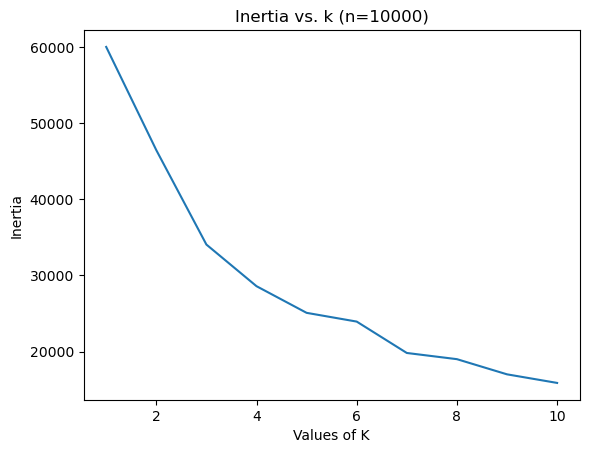

In [19]:
# plt.plot(np.arange(1,11), distortions, 'bx-', label='Distortion')
plt.plot(np.arange(1,11), inertias, label='Intertia')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title(f'Inertia vs. k (n={N})')
# plt.legend()
plt.show()

### trying out k-means with multiple distance metrics

In [20]:
def K_means_time_and_space(data, centroids, max_iter, norm, lam, gam, dist_func):

    # The number of seconds in a day (will need later):
    s = 24 * 60 * 60

    # Already working with arrays, don't need to convert
    # #convert data, centroids Spark dataframes to NumPy arrays
    data_arr = data #np.array(data.collect())
    centroid_arr = centroids #np.array(centroids.collect())

    # set the number of iterations for K-means
    MAX_ITER = max_iter + 1

    # initialize the cost associated with each iteration
    costs = np.zeros(MAX_ITER)


    # outer-most loop for k-means iterations
    for t in np.arange(MAX_ITER):

        # will store the index corresponding to the cluster into which each
        # point is partitioned
        clusters = np.zeros(data_arr.shape[0])

        # will store the new centroids computed from each iteration
        new_centroids = np.zeros([centroid_arr.shape[0], centroid_arr.shape[1]])

        # will store the count of the number of points falling into each
        # cluster
        point_count = np.zeros([centroid_arr.shape[0], 1])


        # loop over each row in the data
        for j in np.arange(data_arr.shape[0]):

            # will store the custom distance from the current row of the data
            # to each centroid
            dists = np.zeros(centroid_arr.shape[0])


            # loop over each centroid
            for i in np.arange(centroid_arr.shape[0]):

              # get the current row, centroid pair
              x_row = data_arr[j]
              c_row = centroid_arr[i]

              # calculate distance
              dists[i] = dist_func(x_row, c_row, lam, gam)

            # determine the (index of the) cluster with the closest centroid
            # to x_row
            clusters[j] = np.argmin(dists)

            # add the current x_row to the row in the array of new centroids
            # corresponding to the cluster x_row falls into
            new_centroids[int(clusters[j]), :] += x_row
            point_count[int(clusters[j])] += 1

            # store the cost(s) associated with the current x_row
            costs[t] += np.power(dists[int(clusters[j])], norm)

        # divide by the number of points in each cluster to obtain the new
        # centroids
        new_centroids = new_centroids / point_count
        centroid_arr = new_centroids


    # return the costs, new centroids, and cluster assignments
    return costs, new_centroids, clusters;

In [21]:
# Set k, the number of clusters for K-means
# Select a small sample (first N) of rows
N = 100
small_data = projected_data.select("*").limit(N)

# Collect working data-set into an array
small_time_and_space = extract_times_to_seconds(small_data)
small_time_and_space_arr = np.array(small_time_and_space.collect())

# normalize data so each feature ranges from zero to one (like sklearn standard scaler-- z = (x - u) / s)
X = small_time_and_space_arr
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

k = 6
lams = np.arange(0, 1.1, 0.1)
gams = np.arange(0, 1.1, 0.1)

meas = []
runtimes = []
silhouettes = []
clusterings = []
lamdas = []
gammas = []

for lam in lams:
    for gam in gams:

        # Pick the first k points as a "random" initialization of centroids
        random_centroids = X[:k]

        # compare sillhouette scores, runtime
        measures = [custom_distance_metric, euclidean_dist] #, dtw, discrete_frechet
        for measure in measures:
            # run algorithm
            t0 = time.time()
            costs, centroids, clustering = K_means_time_and_space(X,
                                    random_centroids,
                                    max_iter = 20, norm = 2,
                                    lam = lam,
                                    gam = gam,
                                    dist_func=measure)
            runtimes.append(time.time()-t0)
            clusterings.append(clustering)
            meas.append(measure)
            lamdas.append(lam)
            gammas.append(gam)

            # compute silhouette
            print(lam, gam, 'computing silhouette')
            overall_score, sample_scores = silhouette_score_custom(X, clustering, measure, lam, gam)
            silhouettes.append(overall_score)
    
# run euclidean distance
# random_centroids = X[:k]
# t0 = time.time()
# e_costs, e_centroids, e_clustering = K_means_time_and_space(X,
#                         random_centroids,
#                         max_iter = 20, norm = 2,
#                         lam = 0,
#                         gam = 0,
#                         dist_func=euclidean_dist)
# e_runtime = time.time()-t0

/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_5090/2163281015.py:65: RuntimeWarning: invalid value encountered in divide
  new_centroids = new_centroids / point_count
/var/folders/mg/5x982c514sl0dc5v1pd9gj580000gn/T/ipykernel_5090/2161610451.py:52: RuntimeWarning: invalid value encountered in scalar divide
  silhouette_scores[i] = (b - a) / np.max([a, b])


0.0 0.0 computing silhouette
0.0 0.0 computing silhouette
0.0 0.1 computing silhouette
0.0 0.1 computing silhouette
0.0 0.2 computing silhouette
0.0 0.2 computing silhouette
0.0 0.30000000000000004 computing silhouette
0.0 0.30000000000000004 computing silhouette
0.0 0.4 computing silhouette
0.0 0.4 computing silhouette
0.0 0.5 computing silhouette
0.0 0.5 computing silhouette
0.0 0.6000000000000001 computing silhouette
0.0 0.6000000000000001 computing silhouette
0.0 0.7000000000000001 computing silhouette
0.0 0.7000000000000001 computing silhouette
0.0 0.8 computing silhouette
0.0 0.8 computing silhouette
0.0 0.9 computing silhouette
0.0 0.9 computing silhouette
0.0 1.0 computing silhouette
0.0 1.0 computing silhouette
0.1 0.0 computing silhouette
0.1 0.0 computing silhouette
0.1 0.1 computing silhouette
0.1 0.1 computing silhouette
0.1 0.2 computing silhouette
0.1 0.2 computing silhouette
0.1 0.30000000000000004 computing silhouette
0.1 0.30000000000000004 computing silhouette
0.1 0.

In [22]:
results = pd.DataFrame({'lambda': lamdas, 'gamma': gammas, 'measure': meas, 'runtime': runtimes, 'silhouette': silhouettes})
# clean up measure column
results['measure'] = results['measure'].apply(lambda x: str(x).split(' ')[1])
# replace custom_distance_metric with "spatiotemporall-aware" and euclidean_dist with "euclidean"
results['measure'] = results['measure']. replace('custom_distance_metric', 'Spatiotemporally-aware')
results['measure'] = results['measure']. replace('euclidean_dist', 'Euclidean')
results

,lambda,gamma,measure,runtime,silhouette
0,0.0,0.0,Spatiotemporally-aware,0.169526,NaN
1,0.0,0.0,Euclidean,0.052771,0.277359
2,0.0,0.1,Spatiotemporally-aware,0.173582,NaN
3,0.0,0.1,Euclidean,0.053570,0.277359
4,0.0,0.2,Spatiotemporally-aware,0.181159,NaN
...,...,...,...,...,...
237,1.0,0.8,Euclidean,0.080523,0.277359
238,1.0,0.9,Spatiotemporally-aware,0.185206,0.570040
239,1.0,0.9,Euclidean,0.053422,0.277359
240,1.0,1.0,Spatiotemporally-aware,0.180199,0.570040


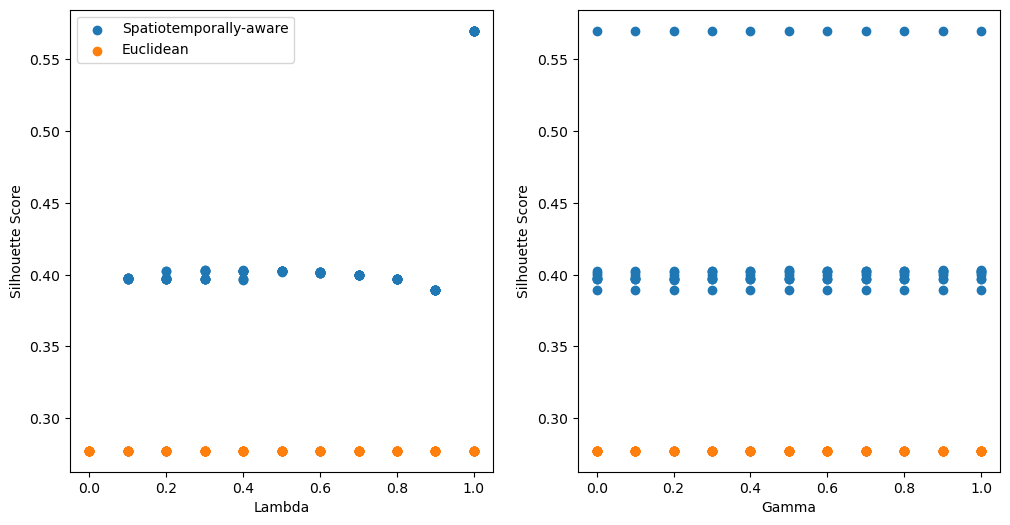

In [26]:
# # plot euclidean vs custom sillhouette results
# lam = alt.Chart(results).mark_circle().encode(
#     x='lambda',
#     y='silhouette',
#     color='measure'
# )

# gam = alt.Chart(results).mark_circle().encode(
#     x='gamma',
#     y='silhouette',
#     color='measure'
# )

# # run times
# lam_time = alt.Chart(results).mark_circle().encode(
#     x='lambda',
#     y='runtime',
#     color='measure'
# )

# gam_time = alt.Chart(results).mark_circle().encode(
#     x='gamma',
#     y='runtime',
#     color='measure'
# )

# alt.vconcat(lam | gam) #, lam_time | gam_time)

# use matplotlib
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for measure in results['measure'].unique():
    sub = results[results['measure'] == measure]
    ax[0].scatter(sub['lambda'], sub['silhouette'], label=measure)
    ax[1].scatter(sub['gamma'], sub['silhouette'], label=measure)
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('Silhouette Score')
ax[0].legend()
ax[1].set_xlabel('Gamma')
ax[1].set_ylabel('Silhouette Score')
# ax[1].legend()

plt.show()

## Altair map with time slider to visualize clusters

In [103]:
# run clustering with n = 10,000
# Set k, the number of clusters for K-means
# Select a small sample (first N) of rows
N = 5000
lam = 1
gam = 0.9
small_data = projected_data.select("*").limit(N)

# Collect working data-set into an array
small_time_and_space = extract_times_to_seconds(small_data)
small_time_and_space_arr = np.array(small_time_and_space.collect())

# normalize data so each feature ranges from zero to one (like sklearn standard scaler-- z = (x - u) / s)
X = small_time_and_space_arr
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

k = 6
random_centroids = X[:k]

costs = []
centroids = []
clusterings = []
# run algorithm
for measure in [custom_distance_metric, euclidean_dist]:
    # run algorithm
    t0 = time.time()
    cost, centroid, clustering = K_means_time_and_space(X,
                            random_centroids,
                            max_iter = 20, norm = 2,
                            lam = lam,
                            gam = gam,
                            dist_func=measure)
    costs.append(cost)
    centroids.append(centroid)
    clusterings.append(clustering)



In [104]:
# crete pandas dataset
# custom metric
custom_df = small_data.toPandas()
custom_df["cluster"] = clusterings[0]
custom_df["started_at"] = pd.to_datetime(custom_df["started_at"], format='%H:%M:%S')
custom_df["ended_at"] = pd.to_datetime(custom_df["ended_at"], format='%H:%M:%S')
custom_df['start_hour'] = custom_df['started_at'].dt.hour

# euclidean
euclidean_df = small_data.toPandas()
euclidean_df["cluster"] = clusterings[1]
euclidean_df["started_at"] = pd.to_datetime(euclidean_df["started_at"], format='%H:%M:%S')
euclidean_df["ended_at"] = pd.to_datetime(euclidean_df["ended_at"], format='%H:%M:%S')
euclidean_df['start_hour'] = euclidean_df['started_at'].dt.hour

In [58]:
# create gdfs for nyc, points
# nyc = gpd.read_file('https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson')
url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Census_Tracts_for_2020_US_Census/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
response = requests.get(url)
nyc_gjson = response.json()
# points = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.start_lng, df.start_lat), crs='EPSG:4326')

In [108]:
# for custom lam =1, gam=0.9
basemap = alt.Chart(alt.Data(values=nyc_gjson['features'])).mark_geoshape(
    fill='lightgrey',
).encode().project(type='albersUsa')

time_slider = alt.binding_range(min=0, max=24, step=1, name='Hour of day:')
time_select = alt.selection_point(fields=['start_hour'], bind=time_slider, value=0)

color_scale = alt.Scale(
    domain=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
    range=['#66c2a5', '#fc8d62', '#8da0cb',  '#e78ac3', '#a6d854', '#ffd92f']
)

points_cust = alt.Chart(custom_df).mark_circle().encode(
    longitude='start_lng:Q',
    latitude='start_lat:Q',
    color=alt.Color('cluster:N', scale=color_scale, legend=alt.Legend(title="Cluster"))
).add_selection(
    time_select
).transform_filter(
    time_select
)

# add title
title_cust = alt.Chart(
    {"values": [{"text": "Spatiotemporally-aware (λ = 1.0) clusters (n=5,000)"}]}
).mark_text(size=20, align='center', dx=0, dy=-170).encode(
    text="text:N"
)

# for euclidean
points_euc = alt.Chart(euclidean_df).mark_circle().encode(
    longitude='start_lng:Q',
    latitude='start_lat:Q',
    color=alt.Color('cluster:N', scale=color_scale, legend=alt.Legend(title="Cluster"))
).add_selection(
    time_select
).transform_filter(
    time_select
)

# add title
title_euc = alt.Chart(
    {"values": [{"text": "Euclidean clusters (n=5,000)"}]}
).mark_text(size=20, align='center', dx=0, dy=-170).encode(
    text="text:N"
)

cluster_results = (basemap + points_cust + title_cust) | (basemap + points_euc + title_euc)
cluster_results.save('figs/cluster_results_interactive.html')
cluster_results

/opt/anaconda3/envs/cse_547/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize = (10, 15))
ax = plt.axes(projection='3d')
fig.tight_layout(pad = 5.0)

ax.scatter(lons, times, lats, c = clustering, cmap = 'viridis', s = 30);

ax.set_xticks([]);
ax.set_zticks([]);
ax.set_yticks(np.linspace(0, 24, 7));

title = ax.set_title("Spatio-temporal clustering: \n Time & Space Balance", fontsize = 20);
ax.set_xlabel("start lon", fontsize = 16);
ax.set_zlabel("start lat", fontsize = 16);
ax.set_ylabel("\n time of day", fontsize = 14);
title.set_position([0.5, 1]);


ax.view_init(10, -10, 0);
ax.dist = 11;